In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.stats import pearsonr 
%matplotlib inline

import math

def sample_queries(df, frac):
    srch_ids = pd.Series(df["srch_id"].unique()).sample(frac=frac, random_state=42)
    return df.loc[df.srch_id.isin(srch_ids)]

train = pd.read_csv("data/training_set_VU_DM_2014.csv")
#test = pd.read_csv("data/test_set_VU_DM_2014.csv")

train = sample_queries(train, 0.1)

train.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
86,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,6492,2,4.0,...,NaN,NaN,NaN,NaN,1.0,0.0,12.0,0,NaN,0
87,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,8946,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
88,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,9952,2,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
89,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,19470,2,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0
90,11,2013-02-25 08:39:33,5,219,NaN,NaN,219,20499,2,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,NaN,0


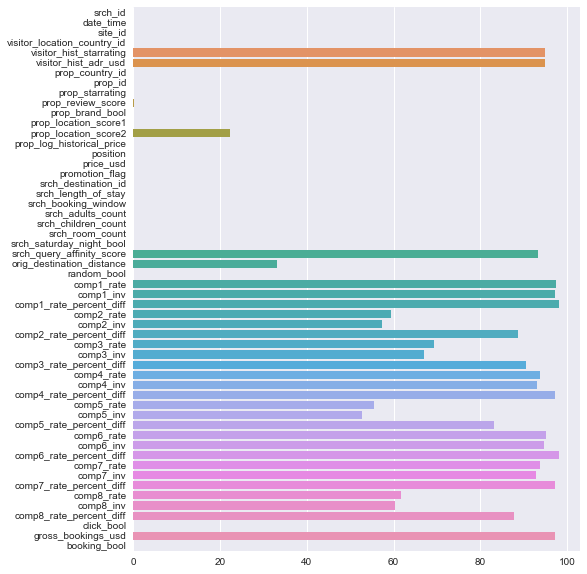

In [36]:
# Missing values
m = train.isnull().sum() / len(train) * 100
plt.figure(figsize=(8, 10))
sns.barplot(x=m.values, y=m.keys())

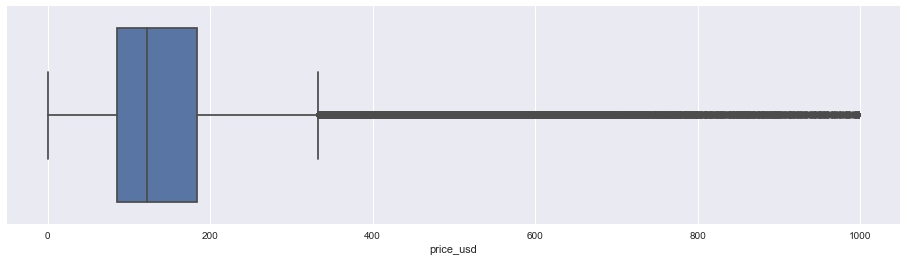

In [37]:
# Price distribution
plt.figure(figsize=(16, 4))
sns.boxplot(x=train.loc[train.price_usd < 1000].price_usd)

In [38]:
train.price_usd.max()

205182.0

In [39]:
(train.price_usd > 1000).mean()

0.0027166997248962805

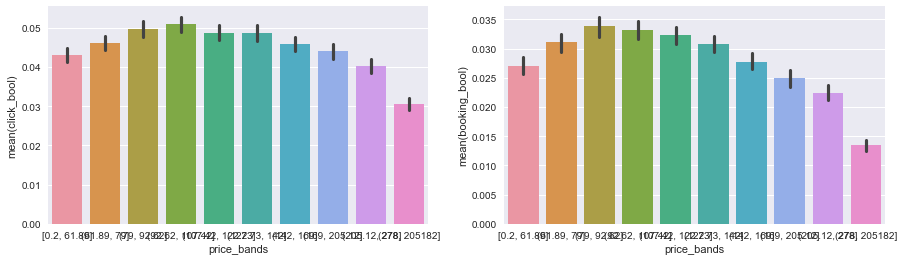

In [41]:
train["price_bands"] = pd.qcut(train.price_usd, 10)
#g = train.groupby("price_bands")

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_bands", y="booking_bool", data=train, ax=axis2)

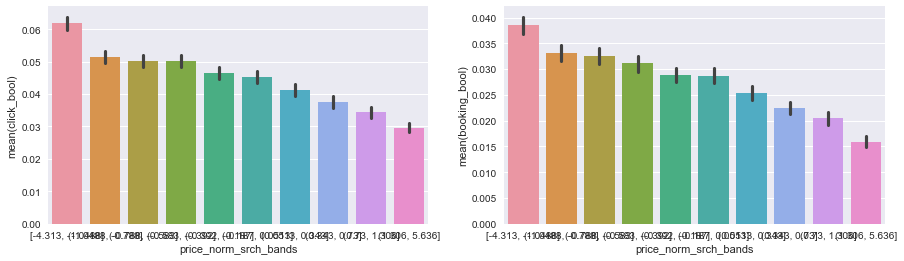

In [43]:
# Normalize prices by srch_id
train["price_norm_srch"] = train.groupby("srch_id")["price_usd"].transform(lambda x: (x - x.mean()) / x.std())
train["price_norm_srch_bands"] = pd.qcut(train.price_norm_srch, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_norm_srch_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_norm_srch_bands", y="booking_bool", data=train, ax=axis2)

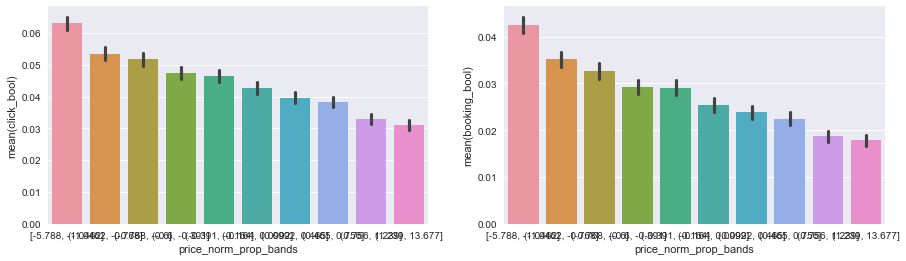

In [44]:
# Normalize prices by prop_id
train["price_norm_prop"] = train.groupby("prop_id")["price_usd"].transform(lambda x: (x - x.mean()) / x.std())
train["price_norm_prop_bands"] = pd.qcut(train.price_norm_prop, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_norm_prop_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_norm_prop_bands", y="booking_bool", data=train, ax=axis2)

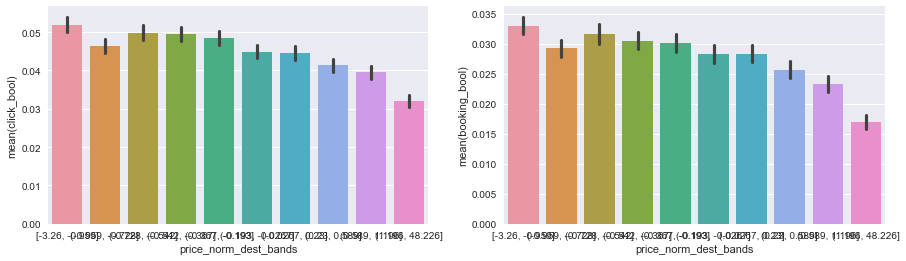

In [45]:
# Normalize prices by both srch_destination_id
train["price_norm_dest"] = train.groupby("srch_destination_id")["price_usd"].transform(lambda x: (x - x.mean()) / x.std())
train["price_norm_dest_bands"] = pd.qcut(train.price_norm_dest, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_norm_dest_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_norm_dest_bands", y="booking_bool", data=train, ax=axis2)

149.53


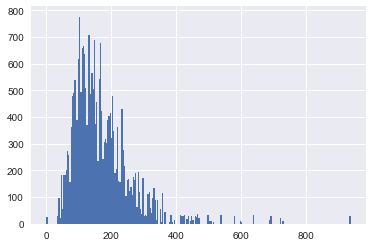

In [46]:
train.visitor_hist_adr_usd.hist(bins=250)
print(train.visitor_hist_adr_usd.median())

3.5


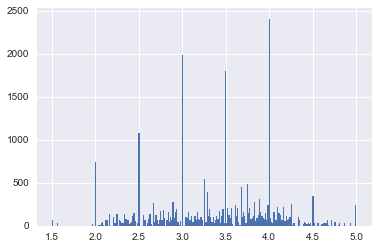

In [47]:
train.visitor_hist_starrating.hist(bins=250)
print(train.visitor_hist_starrating.median())

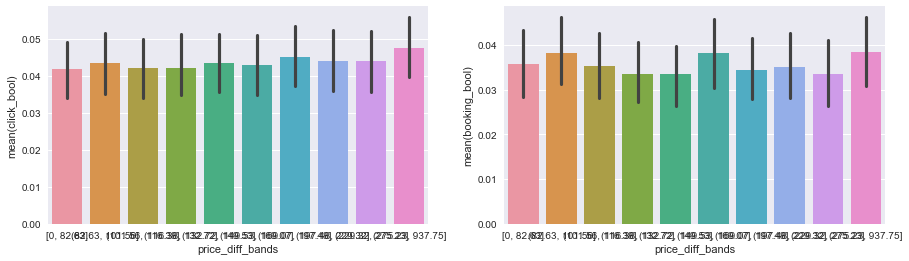

In [63]:
# Price difference between historical price and current price
train["price_diff"] = abs(train.visitor_hist_adr_usd) #- train.price_usd.map(lambda x: 0 if x == 0 else math.log(x, 10)))
train["price_diff_bands"] = pd.qcut(train.price_diff, 10)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="price_diff_bands", y="click_bool", data=train, ax=axis1)
sns.barplot(x="price_diff_bands", y="booking_bool", data=train, ax=axis2)

srch_id
49        270.08
218       185.91
1482       84.89
1543       99.71
1722      223.92
1790      189.89
2380       95.19
2506      140.59
2731      326.92
2801       85.31
2952       78.12
2971      691.75
3060      174.80
3574      170.86
3575       57.18
3615      131.88
3988      268.78
4111      162.51
4267      205.02
4740      105.36
4954      224.97
5314      168.12
5369      139.02
5415      146.79
5506      198.84
5707      109.41
6164       94.42
6231      329.96
6702      176.76
6769      204.11
           ...  
321443    364.25
321542    194.54
322201    296.87
322494    437.41
322601    414.46
322862    198.84
323215    102.37
323263     78.55
323275    298.95
323784    168.29
323904    167.77
324209     85.13
324882    206.79
324990    298.93
325603    315.89
325942     64.06
326607     65.00
326651    249.77
327243    268.48
328278    463.18
328669     86.23
329432    133.41
329496    131.84
330280    204.66
330406     97.67
330454     88.62
330916    130.05
332295

In [ ]:
train["free"] = train["price_usd"].map(lambda x: 1 if x == 0 else 0)

fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15,4))
sns.barplot(x="free", y="click_bool", data=train, ax=axis1)
sns.barplot(x="free", y="booking_bool", data=train), ax=axis2)

In [ ]:
train[["price_norm_srch", "price_norm_prop", "price_norm_dest"]].head()